# Pitch Prediction Model - Grant Nielson

Predicting the outcome of individual pitches proved to be difficult with multiple categorical responses. I tried many models and packages such as
mclogit, brms, and MCMCglmm. I either couldn't get them to work, or was not satisfied with the convergence. I took a vastly different approach and decided to
classify each outcome as good or bad. If there was a pa_result, I overwrote it onto pitch_result since it gave more info about balls hit into play.
This is a risky strategy given that these outcomes are on different levels of 'good' and 'bad', but I felt I might be able to get helpful information later.
I fit a logistic regression model, that didn't tell me much, so I decided to put all the pitch characteristics into a mixed effects model, with pitch_type and pitcher
as the random effects. Sliders were considered the best pitch accross the board, and I was able to rank the top 10 best pitchers with the slider.

I chose a mixed effects model becuase it allows me to treat pitchers as random effects. One hot encoding them would be unefficient and uninformative; random effects help us attach pitch characteristic effects to the pitcher's inherent skill and average outcomes.

In [31]:
library(vroom)
library(dplyr)
library(tidyverse)
library(gt)

df<-vroom('pitch_data.csv')
unique(df$pitch_result)
df$pitch_result <- ifelse(!is.na(df$pa_result), df$pa_result, df$pitch_result)

Rows: 182703 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): game_date, inning_half, pitch_type, pitch_result, pa_result, base_...
dbl (31): game_pk, batter_mlb_player_id, pitcher_mlb_player_id, inning, batt...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Ball"                    "Foul"                   
 [3] "Hit Into Play"           "Called Strike"          
 [5] "Swinging Strike"         "Ball Blocked"           
 [7] "Foul Tip"                "Hit Batter"             
 [9] "Swinging Strike Blocked" "Foul Tip Bunt"          
[11] "Foul Bunt"               "Missed Bunt"            
[13] "Automatic Ball"          "Automatic Strike"       
[15] "Intentional Ball"        "Ball (Pitchout)"        
[17] "Foul (Pitchout)"

[1] "Ball"                           "Foul"                          
 [3] "Out"                            "Called Strike"                 
 [5] "Strikeout"                      "Walk"                          
 [7] "Forceout"                       "Double"                        
 [9] "Swinging Strike"                "Error"                         
[11] "Double Play"                    "Single"                        
[13] "Ball Blocked"                   "Stolen Base (2B)"              
[15] "Wild Pitch"                     "Triple"                        
[17] "Sac Fly"                        "Home Run"                      
[19] "Caught Stealing (Home)"         "Groundout (DP)"                
[21] "Hit By Pitch"                   "Passed Ball"                   
[23] "Swinging Strike Blocked"        "Foul Tip"                      
[25] "Strikeout (DP)"                 "Foul Tip Bunt"                 
[27] "Fielder's Choice"               "Caught Stealing (2B)"          
[29] "Stolen Base (3B)"               "Caught Stealing (3B)"          
[31] "Error (Throw)"                  "Foul Bunt"                     
[33] "Sac Bunt"                       "Fielder's Choice Out"          
[35] "Missed Bunt"                    "Other Advance"                 
[37] "Pickoff (2B)"                   "Hit Into Play"                 
[39] "Automatic Ball"                 "Stolen Base (Home)"            
[41] "Pickoff Error (2B)"             "Pickoff Caught Stealing (2B)"  
[43] "Unknown"                        "Catcher Interference"          
[45] "Automatic Strike"               "Pickoff (3B)"                  
[47] "Intentional Ball"               "Pickoff Error (1B)"            
[49] "Defensive Indifference"         "Ball (Pitchout)"               
[51] "Runner Out"                     "Foul (Pitchout)"               
[53] "Sac Fly (DP)"                   "Pickoff (1B)"                  
[55] "Pickoff Caught Stealing (Home)" "Pickoff Error (3B)"            
[57] "Balk"

In [32]:
# Step 1: Classify pitch_result as good or bad
# Define the lists of bad and good results
bad_results <- c("Ball", "Double", "Single", "Triple", "Wild Pitch", "Passed Ball")
good_results <- c("Foul", "Out", "Called Strike", "Forceout", "Swinging Strike", "Strikeout",
                  "Double Play", "Swinging Strike Blocked", "Foul Tip", "Strikeout (DP)",
                  "Foul Tip Bunt", "Missed Bunt", "Runner Out")

# Create a binary variable for pitch_result: 1 for good, 0 for bad
df <- df %>%
  mutate(
    result_binary = case_when(
      pitch_result %in% good_results ~ 1,
      pitch_result %in% bad_results ~ 0,
      TRUE ~ NA_real_  # Keep other cases as NA if they don't match either list
    )


# filter out rows with NA in result_binary as they don't have a valid result
df <- df %>% filter(!is.na(result_binary))

## Trying Logistic Regression

In [26]:
# it logistic regression model to see which covariates are significant
# select the relevant predictors for the model
logistic_model <- glm(result_binary ~ ., data = df, family = binomial)

summary(logistic_model)
summary_model <- summary(logistic_model)

# coefs to df
coefficients_df <- as.data.frame(summary_model$coefficients)

# rename cols
colnames(coefficients_df) <- c("Estimate", "Std.Error", "z.value", "Pr(>|z|)")

# get p-values <= 0.05
significant_coefficients <- coefficients_df %>% filter(`Pr(>|z|)` <= 0.05)

print(significant_coefficients)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = result_binary ~ ., family = binomial, data = df)

Coefficients:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  6.559e+00  8.305e+00   0.790 0.429682    
game_pk                     -1.372e-05  1.161e-05  -1.182 0.237192    
batter_mlb_player_id         1.360e-06  3.504e-06   0.388 0.697920    
pitcher_mlb_player_id       -1.026e-06  3.224e-06  -0.318 0.750334    
inning                      -2.717e-02  2.072e-01  -0.131 0.895669    
inning_halfTOP               2.240e-01  1.766e-01   1.268 0.204826    
batter_per_game              4.009e-03  3.528e-02   0.114 0.909509    
pitch_per_game              -7.802e-04  5.034e-03  -0.155 0.876824    
home_team_id                 1.092e-02  7.639e-03   1.429 0.152998    
away_team_id                 1.011e-02  7.678e-03   1.316 0.188130    
pitch_speed                  1.176e-02  1.880e-02   0.626 0.531594    
induced_vertical_break      -4.250e-03  1.387e-02  -0.306 0.759

                             Estimate   Std.Error    z.value      Pr(>|z|)
horizontal_break           0.01595773 0.007869335   2.027837  4.257692e-02
hit_coordinates_y          0.01575874 0.002247465   7.011787  2.352935e-12
hit_launch_angle           0.01088525 0.003005297   3.622020  2.923117e-04
balls_pre_event           -0.75945110 0.075773612 -10.022633  1.212297e-23
strikes_pre_event          1.11135957 0.090291819  12.308530  8.149389e-35
base_state_post_event__3  -1.58021579 0.268312239  -5.889466  3.874457e-09
base_state_post_event_2_  -2.26664507 0.234739513  -9.656001  4.636071e-22
base_state_post_event1__  -3.46159819 0.153553449 -22.543279 1.563051e-112
base_state_post_event1_3  -3.24816196 0.435281761  -7.462206  8.508602e-14
base_state_post_event12_  -5.15050064 0.439119939 -11.729143  9.036878e-32
home_score_pre_event      -3.90061170 0.346683239 -11.251227  2.283934e-29
home_score_post_event      3.85114585 0.348059589  11.064616  1.862580e-28
away_score_pre_event     

In [92]:
# Step 1: One-hot encode the pitch_type column using model.matrix
one_hot_encoded <- model.matrix(~ pitch_type - 1, data = df)

# Step 2: Convert the matrix to a data frame for easier merging
one_hot_encoded_df <- as.data.frame(one_hot_encoded)

# Step 3: Merge the one-hot encoded columns back with the original df
# Remove the original pitch_type column and then bind the new one-hot encoded columns
df <- cbind(df %>% select(-pitch_type), one_hot_encoded_df)

# Check the result
head(df)

,game_date,game_pk,batter_mlb_player_id,pitcher_mlb_player_id,inning,inning_half,batter_per_game,pitch_per_game,home_team_id,away_team_id,⋯,result_binary,pitch_typeChangeup,pitch_typeCurveball,pitch_typeCutter,pitch_typeFastball,pitch_typeKnuckleball,pitch_typeSinker,pitch_typeSlider,pitch_typeSplitter,pitch_typeSweeper
,<chr>,<dbl>,<dbl>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,4/8/2022,670551,695653,680632,1,TOP,1,1,94,100,⋯,0,0,0,0,1,0,0,0,0,0
2,4/8/2022,670551,695653,680632,1,TOP,1,2,94,100,⋯,1,0,0,0,1,0,0,0,0,0
3,4/8/2022,670551,695653,680632,1,TOP,1,3,94,100,⋯,1,0,0,0,1,0,0,0,0,0
4,4/8/2022,670551,695653,680632,1,TOP,1,4,94,100,⋯,1,0,0,0,0,0,0,1,0,0
5,4/8/2022,670551,696160,680632,1,TOP,2,5,94,100,⋯,1,0,0,0,1,0,0,0,0,0
6,4/8/2022,670551,696160,680632,1,TOP,2,6,94,100,⋯,1,0,0,0,0,0,0,1,0,0


In [28]:
install.packages('lme4')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘minqa’, ‘nloptr’, ‘RcppEigen’




## Mixed/Random Effects Model

In [94]:
# Load the required package
library(lme4)

# Ensure pitch_type and pitcher_mlb_player_id are factors
df$pitcher_mlb_player_id <- as.factor(df$pitcher_mlb_player_id)

# Fit a logistic mixed-effects model
# Here, result_binary is the binary outcome (1 for good, 0 for bad)
# Fixed effects include the other predictors, and we use random intercepts for both pitch_type and pitcher_mlb_player_id
mixed_model <- glmer(result_binary ~ horizontal_break + pitch_speed + induced_vertical_break +
  pitch_release_coordinates_x + pitch_release_coordinates_z +
                     pitch_location_side_x + pitch_location_height_z + pitch_typeChangeup	+
                     pitch_typeCurveball	+ pitch_typeCutter + pitch_typeFastball +
                     pitch_typeKnuckleball +	pitch_typeSinker + pitch_typeSlider +
                       pitch_typeSplitter +	pitch_typeSweeper + (1 | pitcher_mlb_player_id),
                     data = df, family = binomial)

# View the summary of the mixed-effects model
summary(mixed_model)


fixed-effect model matrix is rank deficient so dropping 1 column / coefficient

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0174083 (tol = 0.002, component 1)”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?;Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?”

Correlation matrix not shown by default, as p = 16 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
result_binary ~ horizontal_break + pitch_speed + induced_vertical_break +  
    pitch_release_coordinates_x + pitch_release_coordinates_z +  
    pitch_location_side_x + pitch_location_height_z + pitch_typeChangeup +  
    pitch_typeCurveball + pitch_typeCutter + pitch_typeFastball +  
    pitch_typeKnuckleball + pitch_typeSinker + pitch_typeSlider +  
    pitch_typeSplitter + pitch_typeSweeper + (1 | pitcher_mlb_player_id)
   Data: df

      AIC       BIC    logLik  deviance  df.resid 
 228031.2  228201.9 -113998.6  227997.2    170191 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.7900 -1.1700  0.7516  0.8188  1.2712 

Random effects:
 Groups                Name        Variance Std.Dev.
 pitcher_mlb_player_id (Intercept) 0.01277  0.113   
Number of obs: 170208, groups:  pitcher_mlb_player_id, 458

Fixed effects:
                        

In [47]:
player_df <- vroom('player_data.csv')

Rows: 829 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): name, birth_date, roster_position_code, bats, throws
dbl (1): player_id

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


player_id,name,birth_date,roster_position_code,bats,throws
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
688815,Anthony Quirion,10/29/1997,C,R,R
621563,Joey Wendle,4/26/1990,SS,L,R
695481,Jay Allen,11/22/2002,OF,R,R
702463,Aaron McKeithan,12/13/1999,C,R,R
693850,Kala'i Rosario,7/2/2002,RF,R,R
684081,Erick Brito,5/25/2002,2B,R,R
684260,Jose Estrada,5/5/2000,C,R,R
694929,Gus Steiger,4/20/1999,SS,R,R
678781,Angel Basabe,12/12/2000,LF,L,L


## Validation

In [95]:
predicted_probs <- predict(mixed_model, type = "response")

# classify
predicted_classes <- ifelse(predicted_probs > 0.5, 1, 0)

actual_classes <- df$result_binary

# Create a confusion matrix
conf_matrix <- table(Predicted = predicted_classes, Actual = actual_classes)
print(conf_matrix)

         Actual
Predicted      0      1
        0   2939    858
        1  65369 101042


In [96]:
TP <- conf_matrix[2, 2]  # True Positives
TN <- conf_matrix[1, 1]  # True Negatives
FP <- conf_matrix[2, 1]  # False Positives
FN <- conf_matrix[1, 2]  # False Negatives

# Calculate metrics
accuracy <- (TP + TN) / sum(conf_matrix)
precision <- TP / (TP + FP)
recall <- TP / (TP + FN)  # Also known as sensitivity
specificity <- TN / (TN + FP)

# Display the metrics
cat("Accuracy:", accuracy, "\n")
cat("Precision:", precision, "\n")
cat("Recall (Sensitivity):", recall, "\n")
cat("Specificity:", specificity, "\n")

Accuracy: 0.6109055 
Precision: 0.6071834 
Recall (Sensitivity): 0.99158 
Specificity: 0.04302571 


`geom_smooth()` using formula = 'y ~ x'


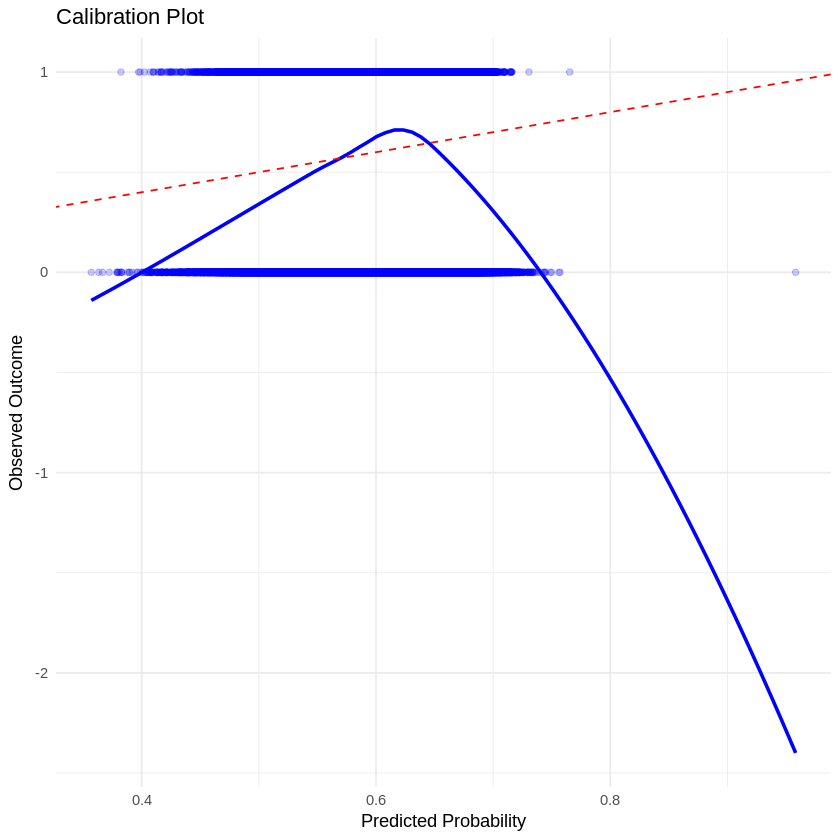

In [100]:
library(ggplot2)

# Step 1: Generate predicted probabilities
# Assuming you've already done this
predicted_probs <- predict(mixed_model, type = "response")

# Step 2: Create a data frame with actual and predicted values
calibration_data <- data.frame(
  predicted_probs = predicted_probs,
  actual = df$result_binary
)

# Step 3: Plot calibration curve using ggplot2
calibration_plot <- ggplot(calibration_data, aes(x = predicted_probs, y = actual)) +
  geom_point(alpha = 0.2, color = "blue") +  # Points for individual observations
  geom_smooth(method = "loess", color = "blue", se = FALSE) +  # LOESS smooth line for calibration curve
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") +  # Ideal diagonal line
  labs(
    x = "Predicted Probability",
    y = "Observed Outcome",
    title = "Calibration Plot"
  ) +
  theme_minimal()

# Display the plot
print(calibration_plot)

Honestly, these predictions aren't great. The calibration plot is no good. It rarely predicts a 'bad' outcome, so Sensitivity is great but Specificity is awful. I am more focused on the pitcher/pitch_type random effects, so prediction is not the most important thing, but I recognzie that this model is a bit poor.

I chose to look at the confusion matrix becuase it lets me how well my preditions are doing from multiple angles besides accuracy. Getting recall and precision helps me know if my model is biased towards certain outcomes. The calibration plot is also nice, because it takes only a second or two to get an idea of how well the model is predicting.

In [99]:
player_df$player_id <- as.character(player_df$player_id)

# join combined_effects_df with player_data
combined_effects_with_names <- combined_effects_df %>%
  left_join(player_df, by = c("pitcher_mlb_player_id" = "player_id"))

combined_effects_with_names <- combined_effects_with_names %>%
  select(name, pitch_type, pitch_type_effect, pitcher_effect, combined_effect, roster_position_code)

# sort by combined effect to view the top and bottom combinations with player names
best_combinations_with_names <- combined_effects_with_names %>%
  arrange(desc(combined_effect)) %>%
  head(20)

worst_combinations_with_names <- combined_effects_with_names %>%
  arrange(combined_effect) %>%
  head(10)


print("Top 10 Best Pitcher and Pitch Type Combinations with Player Names")
print(best_combinations_with_names)

print("Top 10 Worst Pitcher and Pitch Type Combinations with Player Names")
print(worst_combinations_with_names)


[1] "Top 10 Best Pitcher and Pitch Type Combinations with Player Names"
                 name pitch_type pitch_type_effect pitcher_effect
1      Hunter McMahon     Slider        0.18536140      0.2453612
2       Luis Palacios     Slider        0.18536140      0.2316371
3         Pierson Ohl     Slider        0.18536140      0.2248279
4         Joey Steele     Slider        0.18536140      0.1950814
5         Nick Davila     Slider        0.18536140      0.1904212
6       Oswald Medina     Slider        0.18536140      0.1745922
7          Zane Mills     Slider        0.18536140      0.1696061
8       Jeffrey Colon     Slider        0.18536140      0.1664267
9       Jordan Fowler     Slider        0.18536140      0.1657081
10       Carlos Gomez     Slider        0.18536140      0.1625416
11    Inohan Paniagua     Slider        0.18536140      0.1597387
12     Hunter McMahon     Cutter        0.09295516      0.2453612
13        Ben Baggett     Slider        0.18536140      0.1520097
14  

The model loves the slider - it a pitcher throwing a slider increased the probabilty of a "good" defensive outcome the most, on average.

The list is also in fairly straight order for pitcher effects; the only variations being repeat pitcher for different pitch types (Hunter McMahon and Luis Palacios).

This model could be helpful for evaluating hitters if I had included hitters as random effects, which is doable, I just didn't do it here. It could help me learn interactions betwen certain hitters and pitch types, which could help in a matchup model becuase we know what pitch types and pitch charactersitics a certain pitchers will exhibit.